In [1]:
# LIBRAIRIES IMPORT #

import torch
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import doctest

# DEVICE CHECK #

if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


In [72]:
def sample_points(x_dim, method=1, nb_points_omega=4, nb_points_boundary=4):
    """
    Used at the beginning of the process, samples the points in the domain omega and on the boundary of omega.
    
    :param x_dim: dimension of the input space
    :param method: method to sample the points
    :param nb_points_omega: number of points in the domain omega
    :param nb_points_boundary: number of points on the boundary of omega
    :return: the sampled points
    """
    if method == 1:
        in_omega = torch.rand((nb_points_omega, x_dim))

        # We ensure that the number of points on the boundary is a multiple of 4 to simplify the repartition on a squared boundary
        assert isinstance(nb_points_boundary//4, int) 
        points_per_side = nb_points_boundary // 4

        x_left, y_left = torch.zeros((points_per_side, 1)), torch.rand((points_per_side, 1)) 
        print(y_left)
        x_right, y_right = torch.ones((points_per_side, 1)), torch.rand((points_per_side, 1))
        x_bottom, y_bottom = torch.rand((points_per_side, 1)), torch.zeros((points_per_side, 1))
        x_top, y_top = torch.rand((points_per_side, 1)), torch.ones((points_per_side, 1))
        
        on_boundary_x, on_boundary_y = torch.cat((x_left, x_right, x_bottom, x_top)), torch.cat((y_left, y_right, y_bottom, y_top))
        on_boundary = torch.cat((on_boundary_x, on_boundary_y), dim=1)

        return torch.cat((in_omega, on_boundary), dim=0)
    else:
        nb_subdivisions = 10
        assert isinstance(nb_points_omega//nb_subdivisions, int)
        assert isinstance(nb_points_boundary//4, int)
        raise NotImplementedError

def source_term(x, lhs_coeff, dim=2):
    """
    Computes the source term of the PDE at the point x given the coefficients used to generate the PDE solution.

    :param x: point at which the source term is computed, should be in 2D for the moment
    :param lhs_coeff: coefficients used to generate the PDE solution
    :param dim: dimension of the input space
    :return: the value of the source term in R at the point x

    >>> source_term(torch.Tensor([[0., 0.]]), [[1., 0., 0.]])
    tensor([0.])
    >>> source_term(torch.Tensor([[1., 1.]]), [[0., 1985., 0.]])
    tensor([0.])
    """
    x = x.detach().numpy()
    if dim == 2 :
        x1, x2 = x[:, 0], x[:, 1]
        alpha, beta, gamma = lhs_coeff[0]
        source_term = alpha * np.pi**2 * (x1**2 + x2**2) * np.sin(np.pi*(x1 + beta)*(x2 + gamma))
        return torch.Tensor(source_term)
    else :
        raise NotImplementedError

def MC_boundary(nb_points, upper_bound):
    """
    Used for the Monte Carlo process, generates nb_points points on the boundary of the domain [0, upper_bound]^2. 
    We choose randomly the side of the square on which the points are generated.

    :param nb_points: number of points to generate
    :param upper_bound: upper bound of the domain (equals to T)
    :return: the generated points
    """
    assert isinstance(nb_points // 4, int)
    random_boundary = torch.randint(0, 4, (nb_points,))
    x = torch.zeros((nb_points, 2))
    for idx_x, idx_boundary in enumerate(random_boundary):
        if idx_boundary == 0:
            x[idx_x, 0], x[idx_x, 1] = 0, torch.rand(1) * upper_bound
        elif idx_boundary == 1:
            x[idx_x, 0], x[idx_x, 1] = upper_bound, torch.rand(1) * upper_bound
        elif idx_boundary == 2:
            x[idx_x, 0], x[idx_x, 1] = torch.rand(1) * upper_bound, 0
        else:
            x[idx_x, 0], x[idx_x, 1] = torch.rand(1) * upper_bound, upper_bound
    assert(torch.all((x[:, 0] >= 0) & (x[:, 0] <= upper_bound)))
    assert(torch.all((x[:, 1] >= 0) & (x[:, 1] <= upper_bound)))
    return x

def impose_BC(output, MC_points, upper_bound):
    """
    Used for the Monte Carlo process, imposes the boundary conditions on the output of the neural network.
    
    :param output: output of the neural network using MC_points as input.
    :param MC_points: points generated on the boundary of the domain.
    :param upper_bound: upper bound of the domain (equals to T)
    :return: the output with the boundary conditions imposed

    >>> impose_BC(torch.Tensor([[156.85], [145.25], [1.0], [0.]]), torch.Tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]]), 1)
    tensor([[1.],
            [1.],
            [1.],
            [1.]], requires_grad=True)
    """
    assert output.shape[1] == 1
    for ind, (xi, yi) in enumerate(MC_points):
        if xi == upper_bound:
            output[ind] = np.cos(2 * np.pi * output[ind])
        elif xi == 0. or yi == 0. or yi == upper_bound:
            output[ind] = 1.
    output = torch.Tensor(output)
    output.requires_grad = True
    return output

doctest.testmod()

TestResults(failed=0, attempted=3)

In [100]:
# MODEL'S PARAMETERS #

N = 2 # dimension of the input x
m = 100 # dimension of the hidden layers
T = 1 # upper bound of the domain
nb_blocks = 4 # number of blocks in the neural network

# nb_points = 100 

In [1]:
X = sample_points(N, method=1, nb_points_omega=16, nb_points_boundary=64)
shuffle = torch.randperm(X.size(0))

X = X[shuffle]

lhs_coeff = sio.loadmat('lhs_samples.mat')
lhs_coeff = lhs_coeff['lhs_samples']

f_X = source_term(X, [lhs_coeff[4]])

X.requires_grad = True
f_X.requires_grad = True

NameError: name 'sample_points' is not defined

In [5]:
# MODEL DEFINITION #

class Block(torch.nn.Module):
    def __init__(self, m) -> None:
        super(Block, self).__init__()
        self.fc = torch.nn.Linear(m, m)
        self.activation = torch.nn.Tanh()
        # self.activation = lambda x: torch.maximum(x**3, torch.tensor(0.))

    def forward(self, x):
        identity = x
        x = self.fc(x)
        x = self.activation(x)
        x = self.fc(x)
        x = self.activation(x)
        return x + identity
    
class Model(torch.nn.Module):
    def __init__(self, N, m, nb_blocks) -> None:
        super(Model, self).__init__()
        self.fc_in = torch.nn.Linear(N, m)
        self.blocks = torch.nn.ModuleList([Block(m) for _ in range(nb_blocks)])
        self.fc_out = torch.nn.Linear(m, 1)

    def forward(self, x):
        x = self.fc_in(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)
        return x

In [6]:
# TRAINING PARAMETERS #
batch_size = 80
dataset = torch.utils.data.TensorDataset(X)
dataLoader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999
gamma = 500

# MODEL INITIALIZATION #
gen = Model(N, m, nb_blocks)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

# MONTE CARLO PARAMETERS #
M_omega, M_boundary = 2000, 1000

In [7]:
# TRAINING LOOP #

loss_per_epoch = []
loss_terms_per_epoch = np.empty((0, 3))
gen.train()

for epoch in range(num_epochs):
    loss_per_batch = []
    loss_terms_per_batch = np.empty((0, 3))
    for x in dataLoader : 
        output = impose_BC(gen(x[0]).detach().numpy(), x[0], T)

        # gen.eval()
        # Monte Carlo
        mc_omega_x, mc_omega_y = torch.rand(M_omega) * (T - 1e-6), torch.rand(M_omega) * (T - 1e-6)
        mc_omega = torch.stack((mc_omega_x, mc_omega_y), dim=1)
        mc_omega.requires_grad = True
        output_mc = gen(mc_omega)
        source_term_mc = source_term(mc_omega, lhs_coeff)
        grad_output_mc = torch.ones_like(output_mc)
        grad_output_mc = torch.autograd.grad(output_mc, mc_omega, grad_output_mc, create_graph=True, retain_graph=True)[0]
        
        mc_index_boundary = MC_boundary(M_boundary, T)
        output_mc_boundary = gen(mc_index_boundary)
        # output_mc_boundary = impose_BC(output_mc_boundary.detach().numpy(), mc_index_boundary, T)

        L1 = torch.mean(grad_output_mc.square())
        L2 = torch.mean(source_term_mc*output_mc)
        L3 = torch.mean((output_mc_boundary - impose_BC(output_mc_boundary.detach().numpy(), mc_index_boundary, T)).square())
        loss_terms_per_batch = np.vstack((loss_terms_per_batch, np.array([L1.item(), L2.item(), L3.item()])))

        loss = 0.5*L1 - L2 - gamma/2*L3
        loss_per_batch.append(loss.item())

        gen_opt.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(gen.parameters(), 1)
        gen_opt.step()

    loss_terms_per_epoch = np.vstack((loss_terms_per_epoch, np.mean(loss_terms_per_batch, axis=0)))
    loss_per_epoch.append(np.mean(loss_per_batch))

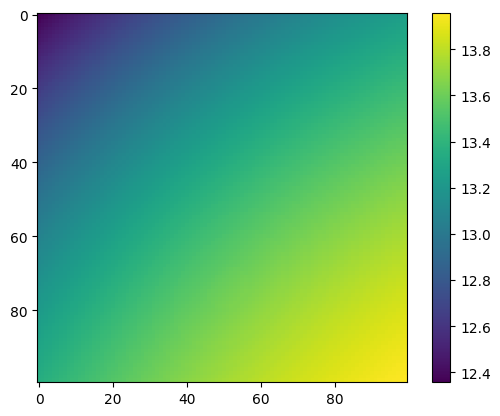

In [8]:
grid_size = 100
x, y = torch.linspace(0, T, grid_size), torch.linspace(0, T, grid_size)
grid = torch.cartesian_prod(x, y)
gen.eval()
output = gen(grid)
plt.imshow(output.detach().numpy().reshape(grid_size, grid_size))
plt.colorbar()

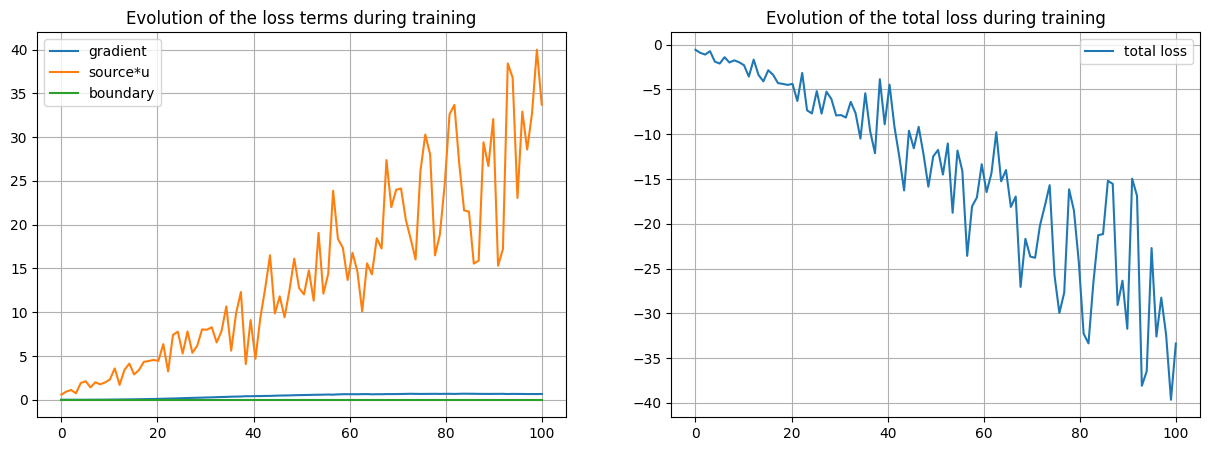

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(0, num_epochs, num_epochs)
ax1.plot(x, loss_terms_per_epoch[:, 0], label='gradient')
ax1.plot(x, loss_terms_per_epoch[:, 1], label='source*u')
ax1.plot(x, loss_terms_per_epoch[:, 2], label='boundary')
ax1.set_title('Evolution of the loss terms during training')
ax1.legend()
ax1.grid()

ax2.plot(x, loss_per_epoch, label='total loss')
ax2.set_title('Evolution of the total loss during training')
ax2.legend()
ax2.grid()
plt.show()

In [10]:
# IMPORTING THE SOLUTION OF THE PDE #
u = sio.loadmat('u.mat')
u = torch.Tensor(np.expand_dims(u['u'], axis=1))